# Refactoring `nowcast.figures`

Render figure objects returned by selected `nowcast.figures` functions.
Provides data from visual testing to confirm that refactoring has not
adversely changed figures for web pages.

Set-up and function calls should replicate as nearly as possible
what is done in `nowcast.workers.make_plots` worker.

In [29]:
from pathlib import Path

import arrow
import netCDF4 as nc
import scipy.io

from nowcast import figures

In [30]:
%matplotlib inline

**NOTE**

The next cell mounts the `/results` filesystem on `skookum` and the `/ocean` filesystem locally.
It is intended for use if when this notebook is run on a laptop or other
non-Waterhole machine that has `sshfs` installed 
and mount points for `/results` and `/ocean` available in its root filesystem.

Don't execute the cell if that doesn't describe your situation.

In [31]:
!sshfs skookum:/results /results
!sshfs skookum:/ocean /ocean

In [32]:
# Relevant part of config from nowcast.yaml file
config = {
    'bathymetry': '/results/nowcast-sys/NEMO-forcing/grid/bathy_meter_SalishSea2.nc',
    'coastline': '/ocean/rich/more/mmapbase/bcgeo/PNW.mat',
    'ssh': {
        'tidal_predictions': '/results/nowcast-sys/tools/SalishSeaNowcast/nowcast/tidal_predictions/',
    },
    'weather': {
        'ops_dir': '/results/forcing/atmospheric/GEM2.5/operational/',
    },
    'run': {
        'results_archive': {
            'forecast': '/results/SalishSea/forecast/'
        },
    },
}

In [33]:
run_date = arrow.get('2016-01-09')
run_type = 'forecast'

dmy = run_date.format('DDMMMYY').lower()
start_day = {
    'forecast': run_date.replace(days=+1).format('YYYYMMDD'),
}
end_day = {
    'forecast': run_date.replace(days=+2).format('YYYYMMDD'),
}
ymd = run_date.format('YYYYMMDD')

results_home = Path(config['run']['results_archive'][run_type])
results_dir = results_home/dmy
place_names = [
    'Point Atkinson', 'Victoria', 'Campbell River', 'Cherry Point',
    'Friday Harbor', 'Neah Bay', 'Nanaimo', 'Sandheads',
]
weather_path = Path(config['weather']['ops_dir'])
if run_type in ('forecast', ('foreacst2')):
    weather_path = weather_path/'fcst'

In [34]:
bathy = nc.Dataset(config['bathymetry'])
grid_T_hr = nc.Dataset(
    str(results_dir/'SalishSea_1h_{0}_{1}_grid_T.nc'
        .format(start_day[run_type], end_day[run_type])))
grids_15m = {
    place_name: nc.Dataset(str(results_dir/'{}.nc'.format(place_name.replace(' ', ''))))
    for place_name in place_names
}
weather_path= str(weather_path)
coastline = scipy.io.loadmat(config['coastline'])
tidal_predictions = config['ssh']['tidal_predictions']

1 loops, best of 1: 10.1 s per loop


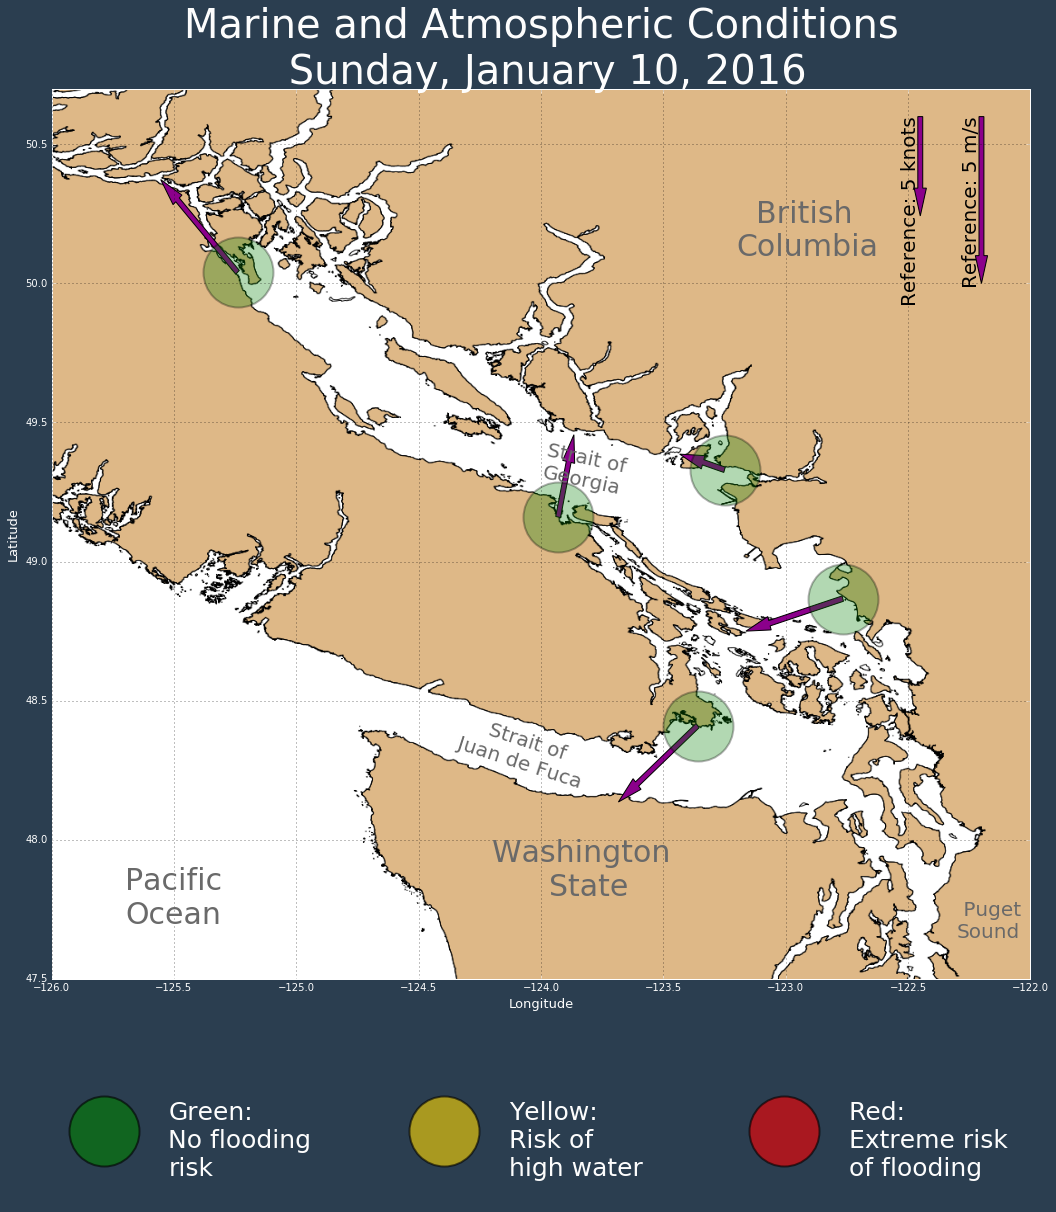

In [77]:
%%timeit -n1 -r1

from importlib import reload
reload(figures)

fig = figures.website_thumbnail(
    bathy, grid_T_hr, grids_15m, weather_path, coastline, tidal_predictions)